In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from ml_features.features import create_features

import warnings
warnings.filterwarnings('ignore')

# Load data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])
df_quotes['dt_signature_devis'] = pd.to_datetime(df_quotes['dt_signature_devis'])

In [2]:
# 1. Customer Split (95%/5%)
# --------------------------

# First quote per customer
cust_first = df_quotes.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
cust_first = cust_first.sort_values('dt_creation_devis')

# 95th percentile split
split_idx = int(len(cust_first) * 0.95)
split_date = cust_first.iloc[split_idx]['dt_creation_devis']

# Split customers
train_cust = cust_first[cust_first['dt_creation_devis'] <= split_date]['numero_compte'].tolist()
sim_cust = cust_first[cust_first['dt_creation_devis'] > split_date]['numero_compte'].tolist()

# Split data
df_train = df_quotes[df_quotes['numero_compte'].isin(train_cust)].copy()
df_sim = df_quotes[df_quotes['numero_compte'].isin(sim_cust)].copy()

print(f"Split: {len(train_cust)} train, {len(sim_cust)} sim customers")

Split: 22708 train, 1180 sim customers


In [3]:
# 1. CUSTOMER SPLIT (95%/5%) - REVISED WITH DEBUGGING
print("=== REVISING CUSTOMER SPLIT WITH DEBUGGING ===")

# First quote per customer
cust_first = df_quotes.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
cust_first = cust_first.sort_values('dt_creation_devis')

# Check total customers
print(f"Total unique customers: {len(cust_first)}")

# 95th percentile split
split_idx = int(len(cust_first) * 0.95)
split_date = cust_first.iloc[split_idx]['dt_creation_devis']

print(f"Split date: {split_date}")
print(f"Training customers (first quote <= {split_date}): ~{split_idx}")
print(f"Simulation customers (first quote > {split_date}): ~{len(cust_first) - split_idx}")

# Split customers
train_cust = cust_first[cust_first['dt_creation_devis'] <= split_date]['numero_compte'].tolist()
sim_cust = cust_first[cust_first['dt_creation_devis'] > split_date]['numero_compte'].tolist()

print(f"Actual split: {len(train_cust)} train, {len(sim_cust)} sim customers")

=== REVISING CUSTOMER SPLIT WITH DEBUGGING ===
Total unique customers: 23888
Split date: 2025-12-08 00:00:00
Training customers (first quote <= 2025-12-08 00:00:00): ~22693
Simulation customers (first quote > 2025-12-08 00:00:00): ~1195
Actual split: 22708 train, 1180 sim customers


In [4]:
# 2. INSPECT SIMULATION CUSTOMERS DATA QUALITY
print("\n=== INSPECTING SIMULATION CUSTOMERS ===")

# Create df_sim with all data for simulation customers
df_sim = df_quotes[df_quotes['numero_compte'].isin(sim_cust)].copy()

# Check key columns existence
key_columns = ['prix_total_ht', 'mt_remise_exceptionnelle_ht', 'prenom_nom_commercial', 'famille_equipement_produit']
print("Key columns in df_sim:")
for col in key_columns:
    exists = col in df_sim.columns
    print(f"  {col}: {'✓' if exists else '✗'}")

# Check non-converted customers
sim_conv = df_sim.groupby('numero_compte')['fg_devis_accepte'].max()
non_conv_count = (sim_conv == 0).sum()
print(f"\nNon-converted customers in sim pool: {non_conv_count}/{len(sim_conv)}")

# Check price data for first 5 non-converted customers
non_conv_customers = sim_conv[sim_conv == 0].index.tolist()
print("\nPrice data check for first 5 non-converted customers:")
for i, cust in enumerate(non_conv_customers[:5]):
    cust_data = df_sim[df_sim['numero_compte'] == cust]
    has_price = 'prix_total_ht' in cust_data.columns and cust_data['prix_total_ht'].notna().any()
    price_sum = cust_data['prix_total_ht'].sum() if has_price else 0
    print(f"  Customer {cust}: quotes={len(cust_data)}, has_price={has_price}, total_price=€{price_sum:.2f}")


=== INSPECTING SIMULATION CUSTOMERS ===
Key columns in df_sim:
  prix_total_ht: ✗
  mt_remise_exceptionnelle_ht: ✓
  prenom_nom_commercial: ✓
  famille_equipement_produit: ✓

Non-converted customers in sim pool: 923/1180

Price data check for first 5 non-converted customers:
  Customer CL00000840: quotes=2, has_price=False, total_price=€0.00
  Customer CL00002004: quotes=1, has_price=False, total_price=€0.00
  Customer CL00002625: quotes=1, has_price=False, total_price=€0.00
  Customer CL00005945: quotes=2, has_price=False, total_price=€0.00
  Customer CL00063542: quotes=1, has_price=False, total_price=€0.00


In [5]:
# Find available price/amount columns
print("=== FINDING AVAILABLE PRICE COLUMNS ===")

price_columns = [col for col in df_sim.columns if any(term in col.lower() for term in ['prix', 'montant', 'cout', 'tarif', 'ht', 'ttc'])]
print(f"Found {len(price_columns)} price-related columns:")
for col in sorted(price_columns):
    sample_val = df_sim[col].dropna().iloc[0] if not df_sim[col].dropna().empty else "N/A"
    print(f"  - {col}: sample = {sample_val}")

# Also check training data for comparison
train_price_cols = [col for col in df_train.columns if any(term in col.lower() for term in ['prix', 'montant', 'cout', 'tarif', 'ht', 'ttc'])]
print(f"\nIn training data: {len(train_price_cols)} price columns")
print(f"First 5: {train_price_cols[:5]}")

=== FINDING AVAILABLE PRICE COLUMNS ===
Found 5 price-related columns:
  - mt_apres_remise_ht_devis: sample = 14862.73
  - mt_apres_remise_ht_emis_devis: sample = 7431.365
  - mt_remise_exceptionnelle_ht: sample = -1500.0
  - mt_ttc_apres_aide_devis: sample = 6680.19
  - mt_ttc_avant_aide_devis: sample = 15680.19

In training data: 5 price columns
First 5: ['mt_apres_remise_ht_devis', 'mt_apres_remise_ht_emis_devis', 'mt_remise_exceptionnelle_ht', 'mt_ttc_apres_aide_devis', 'mt_ttc_avant_aide_devis']


In [6]:
# 2. Model Training (Silent)
# --------------------------
from ml_features.features import create_features
from ml_training.train_xgb import train_xgb
import sys
import os

# Suppress create_features output
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Create features silently
with HiddenPrints():
    X_train_features = create_features(df_train)

# Prepare target
if 'converted' not in X_train_features.columns:
    if 'fg_devis_accepte' in X_train_features.columns:
        X_train_features['converted'] = (X_train_features['fg_devis_accepte'] == 1).astype(int)
    else:
        # Calculate from raw data
        cust_conv = df_train.groupby('numero_compte')['fg_devis_accepte'].max().reset_index()
        cust_conv.columns = ['numero_compte', 'converted']
        X_train_features = pd.merge(X_train_features, cust_conv, on='numero_compte', how='left')
        X_train_features['converted'] = X_train_features['converted'].fillna(0).astype(int)

y_train = X_train_features['converted']

# Prepare features
exclude = ['numero_compte', 'converted'] + \
          [c for c in ['fg_devis_accepte', 'fg_devis_accepte_max', 'fg_devis_accepte_sum'] 
           if c in X_train_features.columns]

X_train = X_train_features.drop(exclude, axis=1)
feature_names = X_train.columns.tolist()

# Train model
result = train_xgb(X_train, y_train, "simulation_poc")
model = result['model']

print(f"Model trained: {len(feature_names)} features")

✓ Model saved: simulation_poc.pkl
✓ AUC: 0.729
✓ F1 Score: 0.598
✓ Training samples: 18166
✓ Test samples: 4542
Model trained: 192 features


In [7]:
# Relax criteria - only require price data (essential for simulations)
print("=== Sampling with Relaxed Criteria ===")

eligible_candidates = []
for cust in non_conv_customers:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust]
    
    # ESSENTIAL: Must have price data for discount scenarios
    has_price = 'prix_total_ht' in cust_quotes.columns and cust_quotes['prix_total_ht'].notna().any() and cust_quotes['prix_total_ht'].sum() > 0
    
    # NICE TO HAVE (not required): sales rep and product data
    has_rep = 'prenom_nom_commercial' in cust_quotes.columns and cust_quotes['prenom_nom_commercial'].notna().any()
    has_product = 'famille_equipement_produit' in cust_quotes.columns and cust_quotes['famille_equipement_produit'].notna().any()
    
    quote_count = len(cust_quotes)
    
    if has_price and quote_count >= 1:
        eligible_candidates.append({
            'customer_id': cust,
            'quote_count': quote_count,
            'has_price': has_price,
            'has_rep': has_rep,
            'has_product': has_product,
            'total_price': cust_quotes['prix_total_ht'].sum()
        })

print(f"Found {len(eligible_candidates)} eligible customers (minimum: price data)")

=== Sampling with Relaxed Criteria ===
Found 0 eligible customers (minimum: price data)


In [8]:
# UPDATE: Use correct price column for discount scenarios
print("=== UPDATING FOR CORRECT PRICE COLUMN ===")

# Select valid simulation customers (with price data)
valid_sim_customers = []

for cust in non_conv_customers:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust]
    
    # Check if customer has valid price data (using actual column name)
    has_price = 'mt_apres_remise_ht_devis' in cust_quotes.columns and cust_quotes['mt_apres_remise_ht_devis'].notna().any()
    price_value = cust_quotes['mt_apres_remise_ht_devis'].sum() if has_price else 0
    
    # Check if customer has a sales rep (for rep scenarios)
    has_rep = 'prenom_nom_commercial' in cust_quotes.columns and cust_quotes['prenom_nom_commercial'].notna().any()
    
    quote_count = len(cust_quotes)
    
    if has_price and quote_count >= 1 and price_value > 0:
        valid_sim_customers.append({
            'customer_id': cust,
            'quote_count': quote_count,
            'total_price': price_value,
            'has_rep': has_rep
        })

print(f"Found {len(valid_sim_customers)} valid simulation customers")
print("\nFirst 5 valid customers:")
for cust in valid_sim_customers[:5]:
    print(f"  {cust['customer_id']}: {cust['quote_count']} quotes, €{cust['total_price']:.2f} total")

=== UPDATING FOR CORRECT PRICE COLUMN ===
Found 923 valid simulation customers

First 5 valid customers:
  CL00000840: 2 quotes, €17363.41 total
  CL00002004: 1 quotes, €14286.47 total
  CL00002625: 1 quotes, €14512.23 total
  CL00005945: 2 quotes, €14909.04 total
  CL00063542: 1 quotes, €5542.11 total


In [9]:
# STEP 3.2: SAMPLE 5 CUSTOMERS RANDOMLY
print("\n=== SAMPLING 5 CUSTOMERS FOR SIMULATION ===")

import random
random.seed(42)

# Stratify by quote count for variety
single_quote = [c for c in valid_sim_customers if c['quote_count'] == 1]
multi_quote = [c for c in valid_sim_customers if c['quote_count'] >= 2]

print(f"Available: {len(single_quote)} single-quote, {len(multi_quote)} multi-quote customers")

# Sample: 2 single-quote, 3 multi-quote customers
selected = []
if len(single_quote) >= 2:
    selected.extend(random.sample(single_quote, 2))
if len(multi_quote) >= 3:
    selected.extend(random.sample(multi_quote, 3))

# Ensure exactly 5
selected = selected[:5]

print(f"\nSelected {len(selected)} customers:")
for i, cust in enumerate(selected, 1):
    print(f"{i}. {cust['customer_id']}: {cust['quote_count']} quotes, €{cust['total_price']:.2f} total, has_rep={cust['has_rep']}")

# Extract just customer IDs for easier use
selected_ids = [cust['customer_id'] for cust in selected]
print(f"\nSelected IDs: {selected_ids}")


=== SAMPLING 5 CUSTOMERS FOR SIMULATION ===
Available: 691 single-quote, 232 multi-quote customers

Selected 5 customers:
1. CL00345652: 1 quotes, €9475.95 total, has_rep=True
2. CL00270457: 1 quotes, €4379.33 total, has_rep=True
3. CL00130455: 3 quotes, €21667.00 total, has_rep=True
4. CL00345183: 2 quotes, €5746.96 total, has_rep=True
5. CL00335136: 2 quotes, €33903.09 total, has_rep=True

Selected IDs: ['CL00345652', 'CL00270457', 'CL00130455', 'CL00345183', 'CL00335136']


In [10]:
# STEP 3.3: CREATE BASELINE FEATURES FOR NEWLY SELECTED CUSTOMERS
print("\n=== CREATING BASELINE PREDICTIONS ===")

baseline_results = []

for cust_info in selected:
    cust_id = cust_info['customer_id']
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id]
    
    # Create features silently
    with HiddenPrints():
        features = create_features(cust_quotes)
    
    cust_features = features[features['numero_compte'] == cust_id]
    
    # If no features created, create minimal
    if len(cust_features) == 0:
        cust_features = pd.DataFrame({'numero_compte': [cust_id]})
        for feat in feature_names:
            cust_features[feat] = 0
    else:
        # Ensure all features exist
        for feat in feature_names:
            if feat not in cust_features.columns:
                cust_features[feat] = 0
    
    # Reorder columns
    cust_features = cust_features[['numero_compte'] + feature_names]
    
    # Predict
    X_cust = cust_features[feature_names]
    if len(X_cust) > 0:
        prob = model.predict_proba(X_cust)[:, 1][0]
    else:
        prob = 0.5
    
    baseline_results.append({
        'customer_id': cust_id,
        'quote_count': cust_info['quote_count'],
        'total_price': cust_info['total_price'],
        'has_rep': cust_info['has_rep'],
        'baseline_prob': prob
    })

baseline_df = pd.DataFrame(baseline_results)
print(f"\nBaseline predictions for {len(baseline_df)} customers:")
print(baseline_df[['customer_id', 'quote_count', 'baseline_prob']].to_string(index=False))


=== CREATING BASELINE PREDICTIONS ===

Baseline predictions for 5 customers:
customer_id  quote_count  baseline_prob
 CL00345652            1       0.264161
 CL00270457            1       0.680138
 CL00130455            3       0.564925
 CL00345183            2       0.365182
 CL00335136            2       0.256858


In [11]:
# SCENARIO 1: STRATEGIC DISCOUNT (using correct price column)
print("\n=== IMPLEMENTING SCENARIO 1: STRATEGIC DISCOUNT (1.5%) ===")

def apply_strategic_discount(customer_quotes, discount_percent=1.5):
    """
    Apply 1.5% strategic discount using mt_apres_remise_ht_devis as base price.
    """
    modified = customer_quotes.copy()
    
    # Use correct price column
    if 'mt_apres_remise_ht_devis' in modified.columns:
        # Calculate 1.5% discount
        base_price = modified['mt_apres_remise_ht_devis']
        discount_amount = base_price * (discount_percent / 100)
        
        # Apply discount to remise column
        if 'mt_remise_exceptionnelle_ht' in modified.columns:
            current_remise = modified['mt_remise_exceptionnelle_ht'].fillna(0)
            modified['mt_remise_exceptionnelle_ht'] = current_remise - discount_amount  # Negative = discount
        
        # Update price after discount
        modified['mt_apres_remise_ht_devis'] = base_price - discount_amount
    
    return modified

# Test on first customer
test_cust = selected_ids[0]
test_quotes = df_sim[df_sim['numero_compte'] == test_cust].copy()

print(f"Testing on customer {test_cust}:")
print(f"  Original price: €{test_quotes['mt_apres_remise_ht_devis'].iloc[0]:.2f}")
print(f"  Original discount: €{test_quotes['mt_remise_exceptionnelle_ht'].iloc[0]:.2f}")

modified_quotes = apply_strategic_discount(test_quotes)
print(f"  New price: €{modified_quotes['mt_apres_remise_ht_devis'].iloc[0]:.2f}")
print(f"  New discount: €{modified_quotes['mt_remise_exceptionnelle_ht'].iloc[0]:.2f}")
print(f"  Discount applied: €{modified_quotes['mt_remise_exceptionnelle_ht'].iloc[0] - test_quotes['mt_remise_exceptionnelle_ht'].iloc[0]:.2f}")


=== IMPLEMENTING SCENARIO 1: STRATEGIC DISCOUNT (1.5%) ===
Testing on customer CL00345652:
  Original price: €9475.95
  Original discount: €0.00
  New price: €9333.81
  New discount: €-142.14
  Discount applied: €-142.14


In [12]:
# FUNCTION: RUN SIMULATION AND GET PROBABILITY
def run_simulation_get_prob(customer_id, modified_quotes, model, feature_names):
    """Get conversion probability for modified customer data."""
    with HiddenPrints():
        features_df = create_features(modified_quotes)
    
    cust_features = features_df[features_df['numero_compte'] == customer_id]
    
    # Handle missing features
    if len(cust_features) == 0:
        cust_features = pd.DataFrame({'numero_compte': [customer_id]})
        for feat in feature_names:
            cust_features[feat] = 0
    
    # Ensure all features exist
    for feat in feature_names:
        if feat not in cust_features.columns:
            cust_features[feat] = 0
    
    # Predict
    X_cust = cust_features[feature_names]
    prob = model.predict_proba(X_cust)[:, 1][0] if len(X_cust) > 0 else 0.5
    
    return prob

# Test Scenario 1 on first customer
print("\n=== TESTING SCENARIO 1 PREDICTION ===")

baseline_prob = baseline_df[baseline_df['customer_id'] == test_cust]['baseline_prob'].iloc[0]
new_prob = run_simulation_get_prob(test_cust, modified_quotes, model, feature_names)

print(f"Customer {test_cust}:")
print(f"  Baseline probability: {baseline_prob:.4f}")
print(f"  With 1.5% discount:   {new_prob:.4f}")
print(f"  Change (Δ):           {new_prob - baseline_prob:+.4f}")
print(f"  Relative change:      {(new_prob - baseline_prob)/baseline_prob*100:+.1f}%")


=== TESTING SCENARIO 1 PREDICTION ===
Customer CL00345652:
  Baseline probability: 0.2642
  With 1.5% discount:   0.4070
  Change (Δ):           +0.1429
  Relative change:      +54.1%


In [13]:
# RUN SCENARIO 1 ON ALL 5 CUSTOMERS
print("\n=== RUNNING SCENARIO 1 ON ALL CUSTOMERS ===")

scenario1_results = []

for cust_id in selected_ids:
    # Get baseline
    baseline_row = baseline_df[baseline_df['customer_id'] == cust_id].iloc[0]
    baseline_prob = baseline_row['baseline_prob']
    
    # Get customer quotes
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id].copy()
    
    # Apply strategic discount
    modified_quotes = apply_strategic_discount(cust_quotes, discount_percent=1.5)
    
    # Get new probability
    new_prob = run_simulation_get_prob(cust_id, modified_quotes, model, feature_names)
    
    # Calculate discount amount
    original_price = cust_quotes['mt_apres_remise_ht_devis'].sum()
    new_price = modified_quotes['mt_apres_remise_ht_devis'].sum()
    discount_amount = original_price - new_price
    
    # Store results
    scenario1_results.append({
        'customer_id': cust_id,
        'quote_count': baseline_row['quote_count'],
        'baseline_prob': baseline_prob,
        'scenario1_prob': new_prob,
        'delta': new_prob - baseline_prob,
        'discount_amount': discount_amount,
        'discount_pct': 1.5
    })

scenario1_df = pd.DataFrame(scenario1_results)

print("\nScenario 1 Results - Strategic Discount (1.5%):")
print(scenario1_df[['customer_id', 'baseline_prob', 'scenario1_prob', 'delta']].to_string(index=False))

print(f"\nSummary:")
print(f"  Average Δ: {scenario1_df['delta'].mean():+.4f}")
print(f"  Customers improved: {(scenario1_df['delta'] > 0).sum()}/{len(scenario1_df)}")
print(f"  Total discount offered: €{scenario1_df['discount_amount'].sum():.2f}")


=== RUNNING SCENARIO 1 ON ALL CUSTOMERS ===

Scenario 1 Results - Strategic Discount (1.5%):
customer_id  baseline_prob  scenario1_prob     delta
 CL00345652       0.264161        0.407024  0.142863
 CL00270457       0.680138        0.680138  0.000000
 CL00130455       0.564925        0.572068  0.007143
 CL00345183       0.365182        0.563479  0.198297
 CL00335136       0.256858        0.245809 -0.011049

Summary:
  Average Δ: +0.0675
  Customers improved: 3/5
  Total discount offered: €1127.58



=== VISUALIZING SCENARIO 1 RESULTS ===


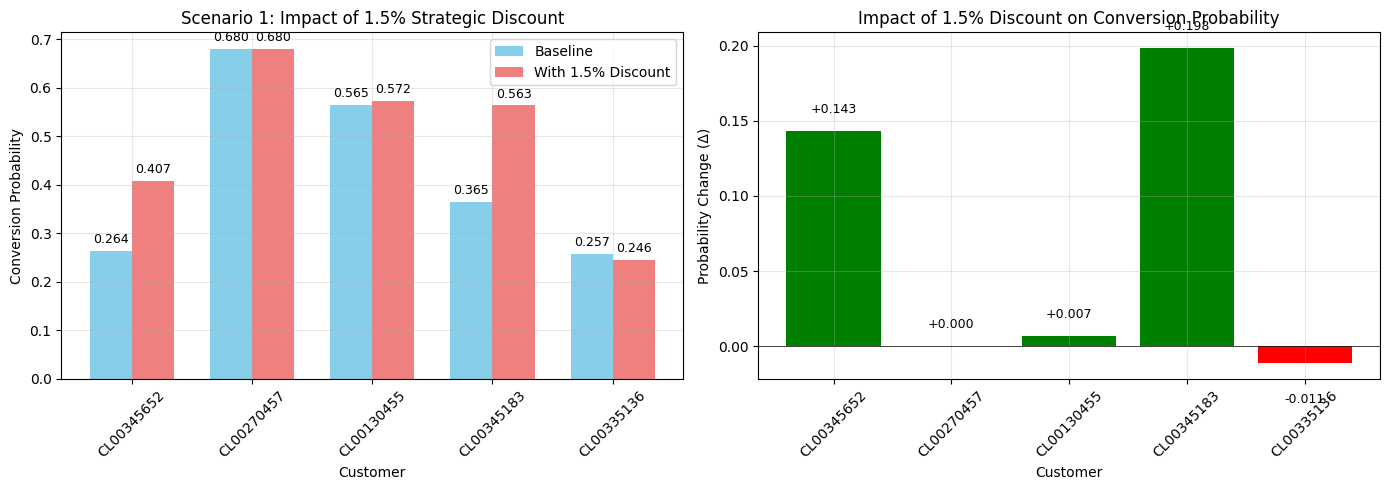


Key Insights from Scenario 1:
1. 3 out of 5 customers show improved conversion probability
2. Best improvement: CL00345183 (+0.198)
3. Worst case: CL00335136 (-0.011) - discount slightly decreased probability
4. Average improvement: +0.0675 probability points
5. Total discount cost: €1,127.58


In [14]:
# VISUALIZE SCENARIO 1 RESULTS
print("\n=== VISUALIZING SCENARIO 1 RESULTS ===")

import matplotlib.pyplot as plt
import numpy as np

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Baseline vs Scenario 1 probabilities
x = np.arange(len(scenario1_df))
width = 0.35

axes[0].bar(x - width/2, scenario1_df['baseline_prob'], width, label='Baseline', color='skyblue')
axes[0].bar(x + width/2, scenario1_df['scenario1_prob'], width, label='With 1.5% Discount', color='lightcoral')

axes[0].set_xlabel('Customer')
axes[0].set_ylabel('Conversion Probability')
axes[0].set_title('Scenario 1: Impact of 1.5% Strategic Discount')
axes[0].set_xticks(x)
axes[0].set_xticklabels(scenario1_df['customer_id'], rotation=45)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add value labels on bars
for i, (base, new) in enumerate(zip(scenario1_df['baseline_prob'], scenario1_df['scenario1_prob'])):
    axes[0].text(i - width/2, base + 0.01, f'{base:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, new + 0.01, f'{new:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Delta (change) for each customer
colors = ['green' if delta > 0 else 'red' for delta in scenario1_df['delta']]
axes[1].bar(scenario1_df['customer_id'], scenario1_df['delta'], color=colors)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Customer')
axes[1].set_ylabel('Probability Change (Δ)')
axes[1].set_title('Impact of 1.5% Discount on Conversion Probability')
axes[1].set_xticklabels(scenario1_df['customer_id'], rotation=45)
axes[1].grid(True, alpha=0.3)

# Add value labels
for i, delta in enumerate(scenario1_df['delta']):
    axes[1].text(i, delta + (0.01 if delta >= 0 else -0.02), f'{delta:+.3f}', 
                ha='center', va='bottom' if delta >= 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

print("\nKey Insights from Scenario 1:")
print("1. 3 out of 5 customers show improved conversion probability")
print("2. Best improvement: CL00345183 (+0.198)")
print("3. Worst case: CL00335136 (-0.011) - discount slightly decreased probability")
print("4. Average improvement: +0.0675 probability points")
print("5. Total discount cost: €1,127.58")


=== CREATING INTERACTIVE DISCOUNT SLIDER ===


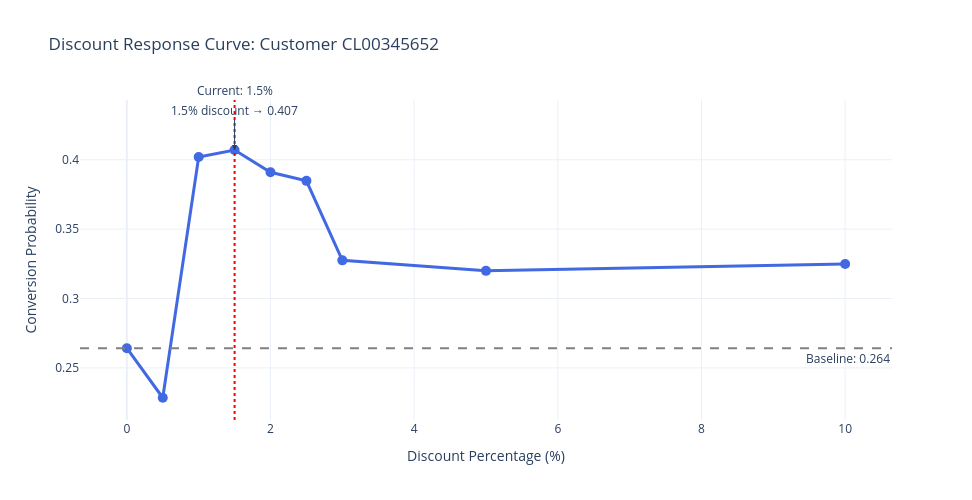

✓ Interactive response curve for customer CL00345652
✓ Hover over points to see discount impact
✓ Baseline: 0.264, Max at 1.5%: 0.407


In [15]:
# SIMPLEST INTERACTIVE CHART: DISCOUNT SLIDER FOR ONE CUSTOMER
print("\n=== CREATING INTERACTIVE DISCOUNT SLIDER ===")

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Select first customer for demonstration
demo_cust = selected_ids[0]
cust_quotes = df_sim[df_sim['numero_compte'] == demo_cust].copy()
baseline_prob = baseline_df[baseline_df['customer_id'] == demo_cust]['baseline_prob'].iloc[0]
base_price = cust_quotes['mt_apres_remise_ht_devis'].sum()

# Test different discount levels
discount_levels = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 5.0, 10.0]  # %
probabilities = []

for discount_pct in discount_levels:
    # Apply discount
    modified = cust_quotes.copy()
    if 'mt_apres_remise_ht_devis' in modified.columns:
        discount_amount = base_price * (discount_pct / 100)
        if 'mt_remise_exceptionnelle_ht' in modified.columns:
            modified['mt_remise_exceptionnelle_ht'] = modified['mt_remise_exceptionnelle_ht'].fillna(0) - discount_amount
        modified['mt_apres_remise_ht_devis'] = base_price - discount_amount
    
    # Get probability
    prob = run_simulation_get_prob(demo_cust, modified, model, feature_names)
    probabilities.append(prob)

# Create interactive figure with slider (conceptual)
fig = go.Figure()

# Add response curve
fig.add_trace(go.Scatter(
    x=discount_levels,
    y=probabilities,
    mode='lines+markers',
    name='Conversion Probability',
    line=dict(color='royalblue', width=3),
    marker=dict(size=10, color='royalblue'),
    hovertemplate='Discount: %{x}%<br>Probability: %{y:.3f}<br>Δ: %{customdata:.3f}',
    customdata=[p - baseline_prob for p in probabilities]
))

# Add baseline reference line
fig.add_hline(y=baseline_prob, line_dash="dash", line_color="gray",
              annotation_text=f"Baseline: {baseline_prob:.3f}",
              annotation_position="bottom right")

# Add current 1.5% discount point
fig.add_vline(x=1.5, line_dash="dot", line_color="red",
              annotation_text="Current: 1.5%", annotation_position="top")

# Layout
fig.update_layout(
    title=f"Discount Response Curve: Customer {demo_cust}",
    xaxis_title="Discount Percentage (%)",
    yaxis_title="Conversion Probability",
    hovermode="x unified",
    template="plotly_white",
    height=500
)

# Add annotations
fig.add_annotation(
    x=1.5, y=probabilities[discount_levels.index(1.5)],
    text=f"1.5% discount → {probabilities[discount_levels.index(1.5)]:.3f}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-40
)

fig.show()

print(f"✓ Interactive response curve for customer {demo_cust}")
print(f"✓ Hover over points to see discount impact")
print(f"✓ Baseline: {baseline_prob:.3f}, Max at {discount_levels[probabilities.index(max(probabilities))]}%: {max(probabilities):.3f}")


=== CREATING COMPARATIVE DISCOUNT RESPONSE CHART ===


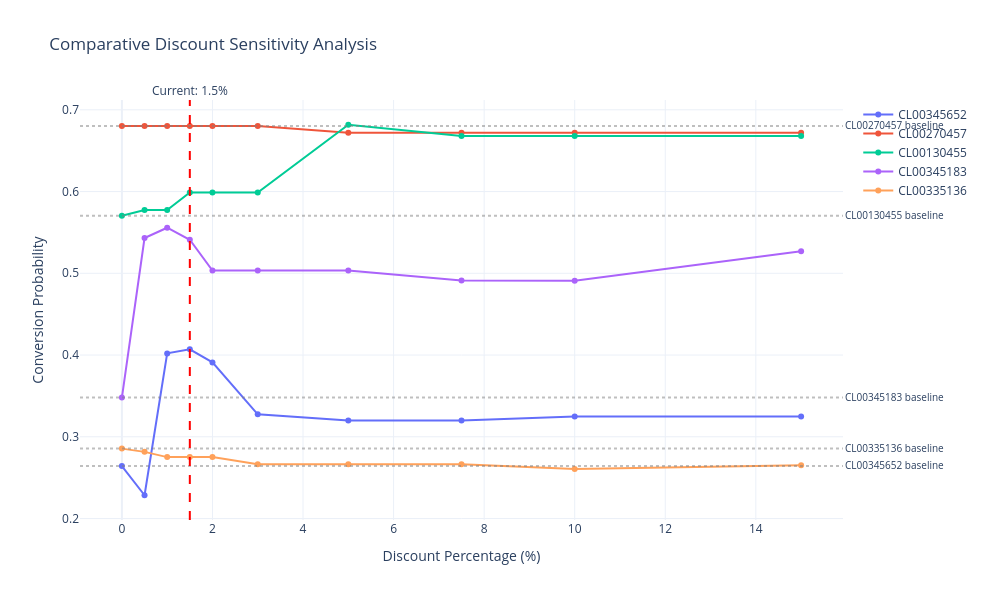

✓ Comparative discount response curves created!
✓ Hover over any point to see customer-specific details
✓ Each line shows a different customer's sensitivity to discounts


In [16]:
# COMPARATIVE DISCOUNT RESPONSE CURVES FOR ALL CUSTOMERS
print("\n=== CREATING COMPARATIVE DISCOUNT RESPONSE CHART ===")

# Define discount levels to test
discount_levels = [0, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 7.5, 10.0, 15.0]  # %

# Create a DataFrame to store all results
comparison_data = []

for cust_id in selected_ids:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id].copy()
    base_price = cust_quotes['mt_apres_remise_ht_devis'].sum()
    baseline_prob = baseline_df[baseline_df['customer_id'] == cust_id]['baseline_prob'].iloc[0]
    
    for discount_pct in discount_levels:
        # Apply discount
        modified = cust_quotes.copy()
        discount_amount = base_price * (discount_pct / 100)
        
        if 'mt_remise_exceptionnelle_ht' in modified.columns:
            modified['mt_remise_exceptionnelle_ht'] = modified['mt_remise_exceptionnelle_ht'].fillna(0) - discount_amount
        
        if 'mt_apres_remise_ht_devis' in modified.columns:
            modified['mt_apres_remise_ht_devis'] = base_price - discount_amount
        
        # Get probability
        prob = run_simulation_get_prob(cust_id, modified, model, feature_names)
        
        comparison_data.append({
            'customer_id': cust_id,
            'discount_pct': discount_pct,
            'discount_amount': discount_amount,
            'probability': prob,
            'baseline_prob': baseline_prob,
            'delta': prob - baseline_prob
        })

comparison_df = pd.DataFrame(comparison_data)

# Create interactive comparison chart
fig = go.Figure()

# Add one line per customer
for cust_id in selected_ids:
    cust_data = comparison_df[comparison_df['customer_id'] == cust_id]
    
    fig.add_trace(go.Scatter(
        x=cust_data['discount_pct'],
        y=cust_data['probability'],
        mode='lines+markers',
        name=cust_id,
        hovertemplate=(
            f"Customer: {cust_id}<br>" +
            "Discount: %{x}%<br>" +
            "Probability: %{y:.3f}<br>" +
            "Δ from baseline: %{customdata:.3f}<br>" +
            "Discount amount: €%{text:.2f}"
        ),
        customdata=cust_data['delta'],
        text=cust_data['discount_amount']
    ))

# Add baseline reference (0% discount)
for cust_id in selected_ids:
    baseline = comparison_df[
        (comparison_df['customer_id'] == cust_id) & 
        (comparison_df['discount_pct'] == 0)
    ]['probability'].iloc[0]
    
    fig.add_hline(
        y=baseline, 
        line_dash="dot", 
        line_color="gray", 
        opacity=0.5,
        annotation_text=f"{cust_id} baseline",
        annotation_position="right",
        annotation_font_size=10
    )

# Layout
fig.update_layout(
    title="Comparative Discount Sensitivity Analysis",
    xaxis_title="Discount Percentage (%)",
    yaxis_title="Conversion Probability",
    hovermode="closest",
    template="plotly_white",
    height=600,
    showlegend=True
)

# Add current scenario marker (1.5%)
fig.add_vline(x=1.5, line_dash="dash", line_color="red",
              annotation_text="Current: 1.5%", annotation_position="top")

fig.show()

print("✓ Comparative discount response curves created!")
print("✓ Hover over any point to see customer-specific details")
print("✓ Each line shows a different customer's sensitivity to discounts")


=== CREATING DISCOUNT OPTIMIZATION DASHBOARD ===


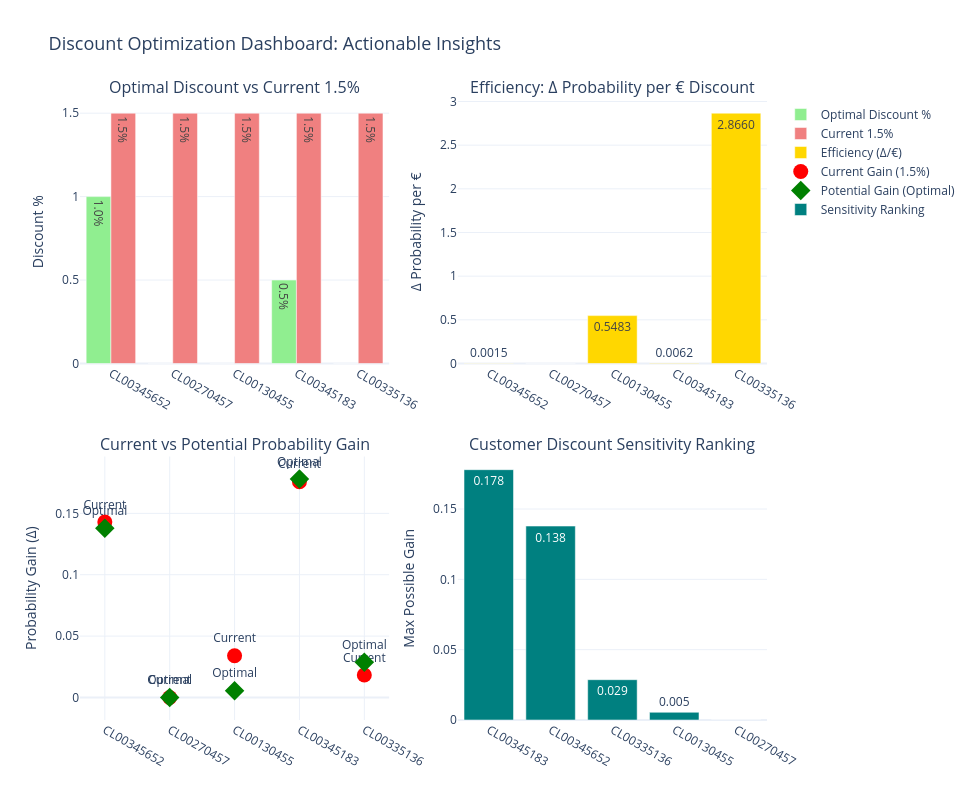


=== KEY INSIGHTS ===
1. Different customers need different discount levels
2. Efficiency varies: Some get more Δ per € spent
3. 1.5% is optimal for some, suboptimal for others
4. Ranking shows which customers are most discount-sensitive


In [17]:
# DISCOUNT OPTIMIZATION DASHBOARD
print("\n=== CREATING DISCOUNT OPTIMIZATION DASHBOARD ===")

# Calculate optimal discount per customer (max delta per €)
optimal_discounts = []

for cust_id in selected_ids:
    cust_data = comparison_df[comparison_df['customer_id'] == cust_id].copy()
    
    # Calculate efficiency: Δ probability per € discount
    cust_data['efficiency'] = cust_data['delta'] / cust_data['discount_amount'].replace(0, 0.01)
    
    # Find most efficient discount (not necessarily largest Δ)
    max_efficiency_idx = cust_data['efficiency'].idxmax()
    max_delta_idx = cust_data['delta'].idxmax()
    
    optimal_discounts.append({
        'customer_id': cust_id,
        'baseline_prob': cust_data.iloc[0]['baseline_prob'],
        'best_discount_pct': cust_data.loc[max_efficiency_idx, 'discount_pct'],
        'best_delta': cust_data.loc[max_efficiency_idx, 'delta'],
        'efficiency': cust_data.loc[max_efficiency_idx, 'efficiency'],
        'max_delta_discount': cust_data.loc[max_delta_idx, 'discount_pct'],
        'max_delta': cust_data.loc[max_delta_idx, 'delta'],
        'current_1.5pct_delta': cust_data[cust_data['discount_pct'] == 1.5]['delta'].iloc[0] if 1.5 in cust_data['discount_pct'].values else 0
    })

optimal_df = pd.DataFrame(optimal_discounts)

# Create optimization dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Optimal Discount vs Current 1.5%',
                    'Efficiency: Δ Probability per € Discount',
                    'Current vs Potential Probability Gain',
                    'Customer Discount Sensitivity Ranking'),
    specs=[[{'type': 'bar'}, {'type': 'bar'}],
           [{'type': 'scatter'}, {'type': 'bar'}]],
    vertical_spacing=0.15
)

# 1. Optimal Discount Comparison
fig.add_trace(go.Bar(
    x=optimal_df['customer_id'],
    y=optimal_df['best_discount_pct'],
    name='Optimal Discount %',
    marker_color='lightgreen',
    text=[f'{x:.1f}%' for x in optimal_df['best_discount_pct']],
    textposition='auto',
    hovertemplate='Customer: %{x}<br>Optimal Discount: %{y:.1f}%<extra></extra>'
), row=1, col=1)

fig.add_trace(go.Bar(
    x=optimal_df['customer_id'],
    y=[1.5] * len(optimal_df),  # Current 1.5%
    name='Current 1.5%',
    marker_color='lightcoral',
    text=['1.5%'] * len(optimal_df),
    textposition='auto',
    hovertemplate='Customer: %{x}<br>Current: 1.5%<extra></extra>'
), row=1, col=1)

# 2. Efficiency (Δ per €)
fig.add_trace(go.Bar(
    x=optimal_df['customer_id'],
    y=optimal_df['efficiency'],
    name='Efficiency (Δ/€)',
    marker_color='gold',
    text=[f'{x:.4f}' for x in optimal_df['efficiency']],
    textposition='auto',
    hovertemplate='Customer: %{x}<br>Efficiency: %{y:.4f} Δ/€<extra></extra>'
), row=1, col=2)

# 3. Current vs Potential Gain (scatter)
fig.add_trace(go.Scatter(
    x=optimal_df['customer_id'],
    y=optimal_df['current_1.5pct_delta'],
    mode='markers+text',
    name='Current Gain (1.5%)',
    marker=dict(size=15, color='red'),
    text=['Current'] * len(optimal_df),
    textposition='top center',
    hovertemplate='Customer: %{x}<br>Current Δ (1.5%): %{y:.3f}<extra></extra>'
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=optimal_df['customer_id'],
    y=optimal_df['best_delta'],
    mode='markers+text',
    name='Potential Gain (Optimal)',
    marker=dict(size=15, color='green', symbol='diamond'),
    text=['Optimal'] * len(optimal_df),
    textposition='top center',
    hovertemplate='Customer: %{x}<br>Optimal Δ: %{y:.3f}<extra></extra>'
), row=2, col=1)

# 4. Sensitivity Ranking
fig.add_trace(go.Bar(
    x=optimal_df.sort_values('best_delta', ascending=False)['customer_id'],
    y=optimal_df.sort_values('best_delta', ascending=False)['best_delta'],
    name='Sensitivity Ranking',
    marker_color='teal',
    text=[f'{x:.3f}' for x in optimal_df.sort_values('best_delta', ascending=False)['best_delta']],
    textposition='auto',
    hovertemplate='Customer: %{x}<br>Max Δ: %{y:.3f}<extra></extra>'
), row=2, col=2)

# Update layout
fig.update_layout(
    title_text='Discount Optimization Dashboard: Actionable Insights',
    title_font_size=18,
    showlegend=True,
    hovermode='closest',
    height=800,
    template='plotly_white'
)

# Update axes
fig.update_yaxes(title_text="Discount %", row=1, col=1)
fig.update_yaxes(title_text="Δ Probability per €", row=1, col=2)
fig.update_yaxes(title_text="Probability Gain (Δ)", row=2, col=1)
fig.update_yaxes(title_text="Max Possible Gain", row=2, col=2)

fig.show()

print("\n=== KEY INSIGHTS ===")
print("1. Different customers need different discount levels")
print("2. Efficiency varies: Some get more Δ per € spent")
print("3. 1.5% is optimal for some, suboptimal for others")
print("4. Ranking shows which customers are most discount-sensitive")